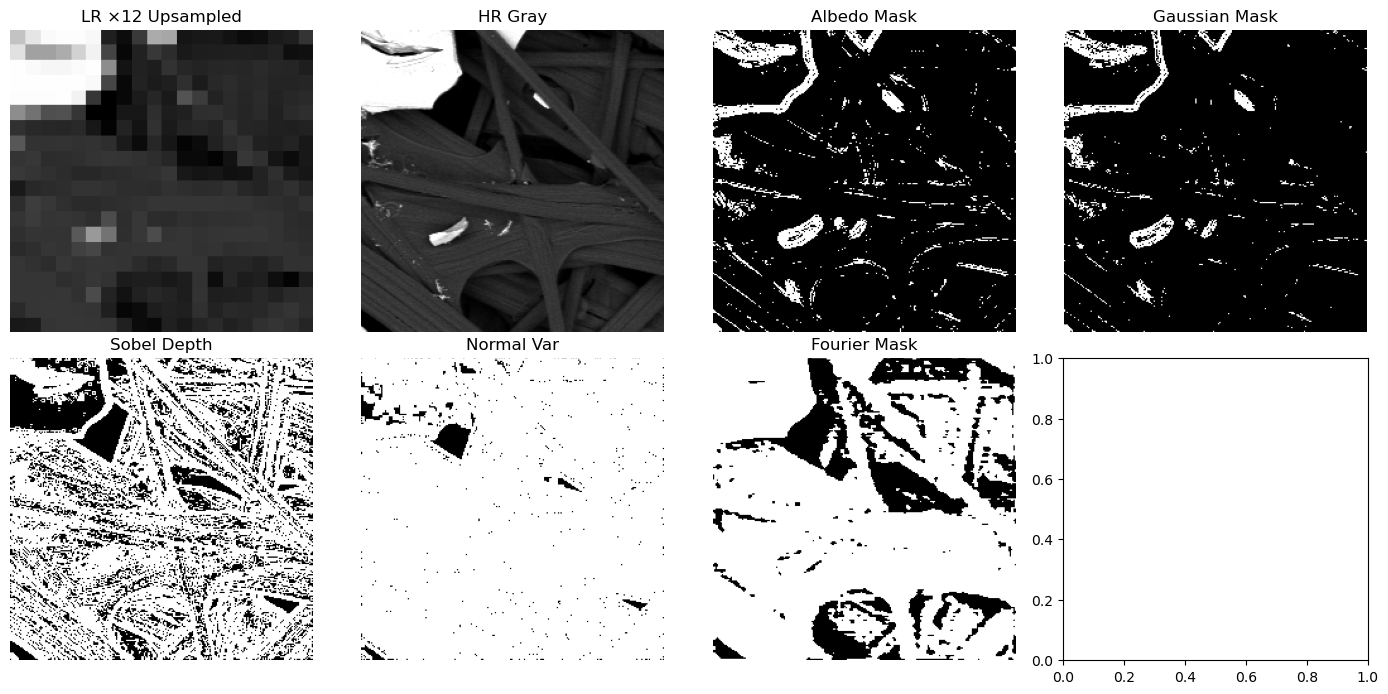

In [10]:


import matplotlib.pyplot as plt
import torch
from loader import NanoDataLoader   # 确保已保存前面的 NanoDataLoader 实现

# ───────────────────────────────────────────────

r = 12
# 1. 创建 DataModule（batch_size=1）
root_dir = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deepfaker/dataset/raw"
data = NanoDataLoader(
    root_dir   = root_dir,
    r          = r,        # 缩放比例
    high_res   = 240,      # HR patch 尺寸
    batch_size = 1         # ← 这里设为 1
)
data.setup()

# ───────────────────────────────────────────────
# 2. 取出一个 batch
lr, hr, fmask = next(iter(data.train_dataloader()))

# 拆分 HR 8 通道
gray_hr = hr[0, 0:3]          # [3,256,256]
albedo  = hr[0, 3]            # [256,256]
gauss   = hr[0, 4]
sobel_d = hr[0, 5]
nvar    = hr[0, 6]
fourier = hr[0, 7]            # 与 fmask 相同

# ───────────────────────────────────────────────
# 3. 可视化
fig, axes = plt.subplots(2, 4, figsize=(14,7))
axes = axes.ravel()

# 低分辨 (先 Upsample 便于观看)
lr_up = torch.nn.functional.interpolate(lr, size=(256,256), mode="nearest")[0]
axes[0].imshow(lr_up.permute(1,2,0).cpu(), cmap="gray")
axes[0].set_title(f"LR ×{r} Upsampled")
axes[0].axis("off")

# HR Gray (取单通道即可)
axes[1].imshow(gray_hr[0].cpu(), cmap="gray")
axes[1].set_title("HR Gray")
axes[1].axis("off")

# 各种 mask
for ax, mask, title in zip(
        axes[2:], 
        [albedo, gauss, sobel_d, nvar, fourier],
        ["Albedo Mask", "Gaussian Mask", "Sobel Depth", "Normal Var", "Fourier Mask"]):
    ax.imshow(mask.cpu(), cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [3]:
from loader import NanoDataLoader
from config import root_dir_1

dm = NanoDataLoader(root_dir=root_dir_1,              # 图像目录
                    r_list=[2, 4, 6, 8, 12],             # 轮换顺序
                    high_res=240,
                    batch_size=1)

for i in range(5):                                    # 连续调用 3 次
    dm.setup()                                        # 相当于 Trainer 重建 dataloader
    lr, hr, fmask, r = next(iter(dm.train_dataloader()))
    print(f"Round {i}:  r = {r}")
    print("  LR :", lr.shape)
    print("  HR :", hr.shape)
    print("  MSK:", fmask.shape, "\n")


Round 0:  r = tensor([2.])
  LR : torch.Size([1, 3, 120, 120])
  HR : torch.Size([1, 8, 240, 240])
  MSK: torch.Size([1, 1, 240, 240]) 

Round 1:  r = tensor([4.])
  LR : torch.Size([1, 3, 60, 60])
  HR : torch.Size([1, 8, 240, 240])
  MSK: torch.Size([1, 1, 240, 240]) 

Round 2:  r = tensor([6.])
  LR : torch.Size([1, 3, 40, 40])
  HR : torch.Size([1, 8, 240, 240])
  MSK: torch.Size([1, 1, 240, 240]) 

Round 3:  r = tensor([8.])
  LR : torch.Size([1, 3, 30, 30])
  HR : torch.Size([1, 8, 240, 240])
  MSK: torch.Size([1, 1, 240, 240]) 

Round 4:  r = tensor([12.])
  LR : torch.Size([1, 3, 20, 20])
  HR : torch.Size([1, 8, 240, 240])
  MSK: torch.Size([1, 1, 240, 240]) 



In [2]:
# ------ notebook cell ------

from lightning import Trainer
from models   import DFSRNet
from loader   import NanoDataLoader
from config   import root_dir_1

# 1) 数据
dm = NanoDataLoader(
    root_dir=root_dir_1,      # 图像目录
    r_list=[2, 4, 6, 8, 12],     # 轮换的放大倍数
    high_res=240,
    batch_size=4,             # demo 用小 batch 省显存
    num_workers=4
)

# 2) 模型（保持与上文一致）
model = DFSRNet(lr_hidc=32, hr_hidc=32, mlpc=64,
                jitter_std=0.001, lr=1e-4, weight_decay=1e-6)

# 3) 训练器 —— 仅跑 5 个 epoch，且每 100 epoch 重建 dataloader
trainer = Trainer(
    max_epochs=5,
    reload_dataloaders_every_n_epochs=100,   # 本测试跑不到 100，但保持一致
    log_every_n_steps=1,
    accelerator="auto",                      # 自动选 CPU / GPU
    devices=1
)

trainer.fit(model, datamodule=dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-590cd023-ff31-c1a2-8267-e0afba042725]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | net     | DFSR              | 1.0 M  | train
1 | loss_fn | CombinatorialLoss | 14.7 M | train
------------------------------------------------------
1.0 M     Trainable params
14.7 M    Non-trainable params
15.8 M    Total params
63.029    Total estimated model params size (MB)
161       Modules in train mode
32        Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [1]:
# train_dfsr.py

from lightning import Trainer
from models   import DFSRNet
from loader   import NanoDataLoader
from config   import root_dir_1

# 1) 数据
dm = NanoDataLoader(
    root_dir=root_dir_1,    
    r_list=[2, 4, 6, 8, 12],     # 轮换的放大倍数
    high_res=240,
    batch_size=32,             # demo 用小 batch 省显存
    num_workers=4
)

# 2) 模型（保持与上文一致）
model = DFSRNet(lr_hidc=32, hr_hidc=32, mlpc=64,
                jitter_std=0.001, lr=1e-4, weight_decay=1e-6)

# 3) 训练器 —— 仅跑 5 个 epoch，且每 100 epoch 重建 dataloader
trainer = Trainer(
    max_epochs=5,
    reload_dataloaders_every_n_epochs=100,
    log_every_n_steps=1,
    accelerator="auto",               
    devices=1
)

trainer.fit(model, datamodule=dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-07 03:24:41.799011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 03:24:41.812131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 03:24:41.826476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 03:24:41.831295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
